# Photo collection social network graph

Digital pictures include lots of information in their metadata, including the date when the picture was taken, and the camera model and settings. Moreover, that metadata is able to hold additional information in its EXIF, IPTC and XMP spaces, such as a series of keywords (tags, even in hierarchical form), the people that appear in the picture and the location where the picture was taken (as gps coordinates or as a geographical description).

This is information that can be visualized in most picture managers, useful to understand the context of the photo, but it's only when a picture collection is explored as a whole that we can observe some interesting patterns.

In this project, we'll explore the social relationships between the people appearing in a photo collection by creating **social network graphs based on how often pairs of people appear together**.

## Data acquisition
Since most cameras do not include information about the people present in a picture, or do not store it in the metadata, the face recognition process often needs to be done using some external tool. Nowadays, most picture managers (both for desktop and mobile devices) include some form of face recognition, although not all of them save that information in a standardized way that can be easily extracted. For our purpose, we need a picture manager that 1) is able to save that kind of information (face regions) in the photo metadata, 2) does it following a standard, and 3) gathers all that information and stores it in an accessible database.

*Digikam* ([www.digikam.org]()) is a free and open source digital asset manager that meets all these criteria. Is able to perform face recognition and save the result both in the XMP metadata and in its `sqlite3` database, that we are able to query.

### SQL query
We use the `sqlite3` library to import digikam's sqlite3 database:

In [33]:
import sqlite3
con = sqlite3.connect("/home/marc/Imatges/digikam4.db")
cur = con.cursor()

Run the query and store the output.
Two tables are relevant for our purpose: 
- `ImageTags`, that contains a list of `tagid` for each `imageid`.
- `TagProperties`, that contain information about each tag, including its name (`TagProperties.value`) and whether it's associated with a person (`TagProperties.property = person`)

In general terms, we are interested in counting each instance of a single `imageid` that contains two `tagid` that belong to people. The final result will be a list of people pairs and a count of how often they appear in pictures together.

In [34]:
res = cur.execute("""
    SELECT A.tagid, T1.value, B.tagid, T2.value, count(DISTINCT A.imageid) AS count
    FROM ImageTags A, ImageTags B
    INNER JOIN TagProperties T1
    ON A.tagid = T1.tagid
    INNER JOIN TagProperties T2
    ON B.tagid = T2.tagid
    WHERE A.tagid IN (
            SELECT tagid FROM TagProperties
            WHERE property = 'person' AND value NOT NULL) 
	    AND A.imageid = B.imageid
	AND T2.value IS NOT NULL
    GROUP BY A.tagid, B.tagid
    ORDER BY count(T1.value) DESC""")
output = res.fetchall() #	    add 'AND A.tagid <> B.tagid' if you want to ignore counts of one person with itself.

### Data cleaning
Convert query output into `Pandas` dataframe (`df`) and clean up the data:

In [35]:
import pandas as pd
df = pd.DataFrame(output)
df.rename(columns={0: 'tagid_1', 1: 'Person_1', 2: 'tagid_2', 3: 'Person_2', 4: 'count'}, inplace=True)
#display(df)

**Scrambling text**

Ofuscating names from the database for privacy reasons.

In [36]:
import random

# Shuffles words respecting whitespaces
def shuffle_word(words):
    random.seed(102)
    words_new = words.split(" ")
    out=''
    for word in words_new:
        l = list(word)
        if word.istitle():
            result = ''.join(random.sample(word, len(word)))
            out = out + ' ' + result.title()
        elif any(i in word for i in ('!','.',',')):
            result = ''.join(random.sample(word[:-1], len(word)-1))
            out = out + ' ' + result+word[-1]
        else:
            result = ''.join(random.sample(word, len(word)))
            out = out +' ' + result
    return (out[1:])

In [37]:
person_1_scrambled = pd.Series([shuffle_word(words) for words in df['Person_1']])
person_2_scrambled = pd.Series([shuffle_word(words) for words in df['Person_2']])
df['Person_1'] = person_1_scrambled
df['Person_2'] = person_2_scrambled

First, let's explore the data.

We observe that there are 19962 unique people pairs that appears in our photo collection. However, half of these only appear in two pictures or less. On average, a people pair will be tagged in 13 pictures.

In [38]:
print(df.shape)
display(df.sample(n = 10)) # Show 10 random rows
display(df['count'].describe())

(20034, 5)


,tagid_1,Person_1,tagid_2,Person_2,count
10157,1952,Uisl Teurad Aredu,1585,Armía Alel Solarc,3
10144,1947,Naioagst Creolu Gloalge,1958,Avdid Rítnma Oerlcu,3
4021,2578,Aercmn Rnanoja,533,Oséj Ervio Zvleé,9
18882,2637,Ana Aaírm Cschueo,1594,Arcme Csaoplia Uaemnl,1
961,5547,Eerfjfy,5547,Eerfjfy,32
1246,283,Xetll Leázpe Tapro,283,Xetll Leázpe Tapro,25
12905,1930,ma(re Riama )Iorbu,311,Ngael Lelgoga Llae,2
17615,2280,Oirsrao Izur,82,Croaiivt Vdarsalae Ilucamsl,1
11260,7,Ieqmul Luaspa Noelorcs,1122,Oíuajqn Rezpé Oedoml,2
10893,2649,Oajna,2649,Oajna,3


count    20034.000000
mean        13.276180
std        129.741868
min          1.000000
25%          2.000000
50%          3.000000
75%          7.000000
max      10416.000000
Name: count, dtype: float64

Cleanup the dataset. Remove leading and trailing backspaces and remove self-referenced pairs of tags pictures. Also a subset the dataset (`df_trim`) so only those people that appear in 50 pictures or more are represented. It could be useful if we encounter performance problems processing the whole dataset.

In [39]:
df.replace(r"^ +| +$", r"", regex=True, inplace=True)   # Replace leading and trailing spaces
df_trim = df[df['Person_1'] != df['Person_2']]          # Avoids people to be linked with themselves. That would only show the number of photos where each person appears.
df_trim = df_trim[df_trim['count']>=30]                 # Only keep those rows with more than X matches.

display(df_trim)

,tagid_1,Person_1,tagid_2,Person_2,count
8,7,Ieqmul Luaspa Noelorcs,42,Croaiivt Lelgoga Ravasdlae,2317
9,42,Croaiivt Lelgoga Ravasdlae,7,Ieqmul Luaspa Noelorcs,2317
10,53,Ot Uellllc Eogallg,277,Max Ellullc Eogallg,1544
11,277,Max Ellullc Eogallg,53,Ot Uellllc Eogallg,1544
13,33,Arcm Usaalp Eogallg,907,Anrmia Rectma Aegotr,1476
...,...,...,...,...,...
1599,1961,Etnbio Rítnma Ueoízrrdg,49,Netsarotrm Eogallg Alsdaarev,31
1608,42,Croaiivt Lelgoga Ravasdlae,89,Riool Toencyaa Aglraiue,30
1609,42,Croaiivt Lelgoga Ravasdlae,342,Aevxir Anapl Dravasale,30
1614,89,Riool Toencyaa Aglraiue,42,Croaiivt Lelgoga Ravasdlae,30


## People tag distribution
We observed that some people pairs contain the same person on both sides. That value basically indicates on how many different pictures a person has been tagged. We can easily extract that information and plot the results to see how people are distributed in the photo library.

Only a very small subset of people are responsible for most of the appearances in the pictures. Of a total of **1284** different people, 50% of people appear in 6 pictures or less, 75% in 23 pictures or less, and 90% in 72 pictures. The person with the highers number of tagged photos appears in 10343 pictures, while only 11 people are tagged in more than 1000 pictures.

That distribution can easily be displayed using a histogram or a bar plot.

Descriptive statistics:


,count
count,1290.000000
mean,67.737209
std,470.916977
min,1.000000
25%,2.000000
50%,6.000000
75%,23.000000
max,10416.000000


People in the 90 percentile:


count    73.2
Name: 0.9, dtype: float64

People in the 99 percentile:


count    691.92
Name: 0.99, dtype: float64

People in the trimmed dataframe (appear in 50 pictures or less):


198

,Person_1,count
0,Arcm Usaalp Eogallg,10416
5,Croaiivt Lelgoga Ravasdlae,6795
1,Ieqmul Luaspa Noelorcs,5807
7,Netsarotrm Eogallg Alsdaarev,4873
2,Max Ellullc Eogallg,4792
...,...,...
574,Onsia Lelgoga Iubro,50
570,Earfrn Laupa,50
572,Iocvtr Ázzegnlo Omilaral,50
571,Arsah Iesrbsèu,50


Duplicated people:


,Person_1,count
99,Arcm Largiua Llrseo,552
37,Arcm Largiua Llrseo,550
73,Arcm Largiua Llrseo,528
74,Arcm Largiua Llrseo,528


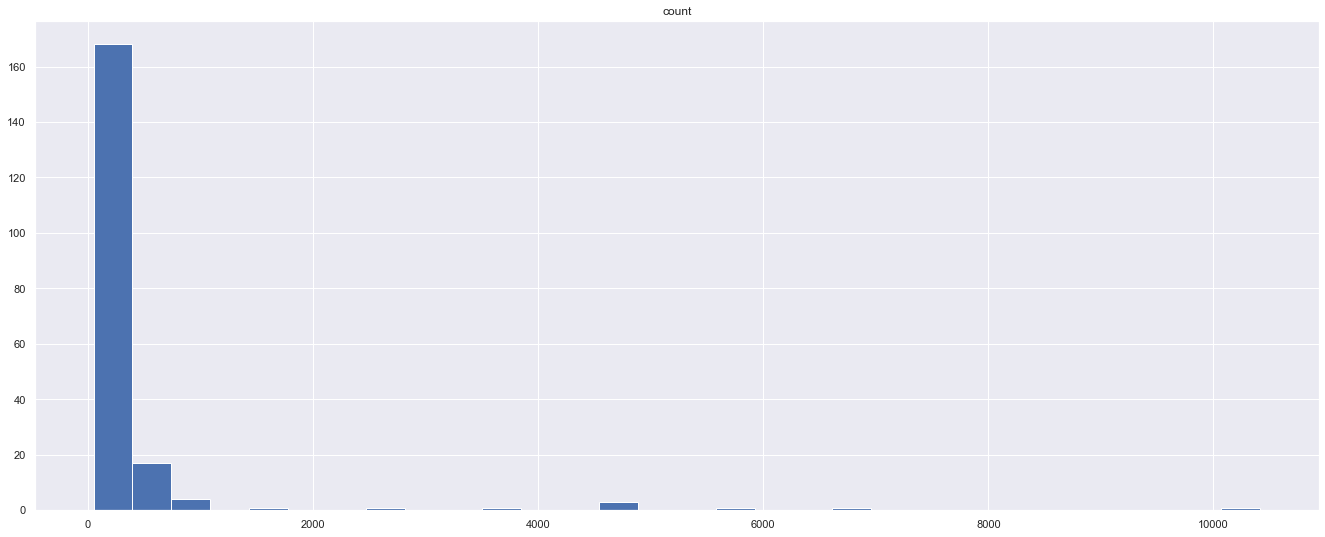

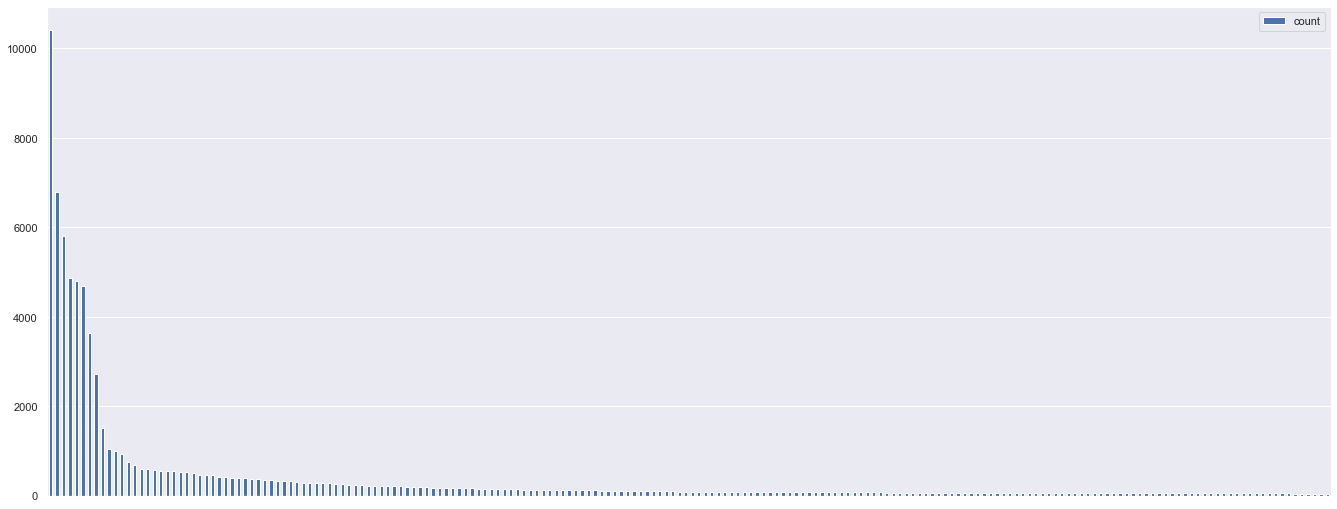

In [40]:
df_people_rank = df[df['Person_1'] == df['Person_2']][['Person_1', 'count']]
df_people_rank.sort_values(by=['count'], ascending=False, inplace=True)

print("Descriptive statistics:")
display(df_people_rank.describe())
print("People in the 90 percentile:")
display(df_people_rank.quantile(0.90))
print("People in the 99 percentile:")
display(df_people_rank.quantile(0.99))

# Trim the dataframe, only keep people with 50 pictures or more
df_people_rank = df_people_rank[df_people_rank['count']>=50]
print("People in the trimmed dataframe (appear in 50 pictures or less):")
display(df_people_rank['Person_1'].count())

df_people_rank.hist(bins=30)
display(df_people_rank)

# Let's take a moment to see if there are duplicated values:
print("Duplicated people:")
display(df_people_rank[df_people_rank['Person_1'].isin(df_people_rank['Person_1'][df_people_rank['Person_1'].duplicated()])].sort_values("Person_1"))

plot = df_people_rank.plot.bar(x="Person_1", y="count")
plot.axes.get_xaxis().set_visible(False)

## Social network graphs
It's time to display these people relationships in form of an interactive social network graph. We'll use the `pyvis` library for that purpose. Also, two functions (`get_edges` and `draw_network`) will be ready to simplify the graph creation based on our dataframe.

In [41]:
from pyvis.network import Network
net = Network()

Function to get a list of edges with weights:

(adapted from: [https://towardsdatascience.com/pyvis-visualize-interactive-network-graphs-in-python-77e059791f01]())

In [42]:
def get_edges(node: str, weights: list, all_nodes: list, minium_weight: int, maximum_weight: int):
    
    nodes = all_nodes.copy()
    
    # Remove target node
    #print("node: " + node)
    #nodes.remove(node) # disabled, as it created wrong relationshipts in the edges

    
    # Create a list of edges with weights
    edges = [(node, connection, weight) for connection, weight in zip(nodes, weights)]
    #print(edges)
    
    # Get only edges with weights greater than the minimum weight
    edges = [edge for edge in edges if edge[2] >= minium_weight]

    # Get only edges with weights smaller than the maximum weight
    edges = [edge for edge in edges if edge[2] <= maximum_weight]
    
    return edges

Function to create the entire network graph:

(adapted from: [https://towardsdatascience.com/pyvis-visualize-interactive-network-graphs-in-python-77e059791f01]())

The appearance and behavior of the graph can be customized. The css portion of the code below passes that configuration to the graph to be generated.

In [43]:
def draw_network(
    nodes: list,
    df: pd.DataFrame,
    minimum_weight: int = 0,
    maximum_weight: int = 10,
    repulsion: int = 100,
    spring_length = 200,
):
    
    net = Network("1080px", "100%", notebook=False)
    

    net.add_nodes(nodes) 

    # add edges
    for node, weights in df.iterrows():
        edges = get_edges(node, weights, nodes, minimum_weight, maximum_weight)
        net.add_edges(edges)

    # change node distance and spring length
    #net.repulsion(repulsion, spring_length=spring_length)

    
    options = """
      var options = {
        "configure": {
              "enabled": true
        },
        "nodes": {
          "font": {
            "size": 30
          }
        },
        "edges": {
          "color": {
            "color": "#9dc6e3",
            "highlight": "#42f5bf"
          }
        },
        "physics": {
          "forceAtlas2Based": {
            "springLength": 100
          },
          "minVelocity": 0.75,
          "solver": "forceAtlas2Based"
        }
      }
      """
    net.set_options(options)
    #net.force_atlas_2based() # already set in the set_options()
    return net

### Global social graph

#### Preparing the data

Pivot table: 
We first start from converting our dataframe to a more suitable format using a pivot table. We want to create a matrix (`df_matrix`) where each row and column headers represent one person, and the value is the amount of matching pictures.

The trimmed dataframe (`df_trim`) will be used to save resources and only show the more meaningful relations, but the whole dataset (`df`) could be used instead if our goal is to be as exhaustive as possible.

With the trimmed dataframe, we obtain a matrix of 84x84.

In [44]:
df_matrix = df_trim.pivot_table(index='Person_1', columns='Person_2', values='count', fill_value=0) # Change df_trim to df for the non-trimmed dataset
df_matrix.reset_index(drop=True)

# Sort the resulting dataframe based on mean values
df_matrix = df_matrix.reindex(df_matrix.mean().sort_values(ascending=False).index, axis=1)
df_matrix = df_matrix.reindex(df_matrix.mean().sort_values(ascending=False).index, axis=0)

display(df_matrix)

Person_2,Croaiivt Lelgoga Ravasdlae,Arcm Usaalp Eogallg,Netsarotrm Eogallg Alsdaarev,Ieqmul Luaspa Noelorcs,Ot Uellllc Eogallg,Max Ellullc Eogallg,Ana Saañc Cblaearol,Anrmia Rectma Aegotr,Mieala Rottaso Earvla,Osej Nionota Nmría Iubro,...,Anrmia Radbíja Gpiu,Ualjin Creolu Ispri,Nlgáea Lelgoga Llae,Esrtea Gaasrmoo,Avdid Mnéjzei i Etobni,Armía Lreome Oopz,Errgad Aurg,Olal uianre(c bs)niuu,Liogra Jdapsau Eonmro,Lexà Zdreíugro Iaardbct
Person_2,,,,,,,,,,,,,,,,,,,,,
Croaiivt Lelgoga Ravasdlae,0,947.0,1150,2317,619,625,499,41,346,328,...,0,0,0,0,0,0,0,0,0,0
Arcm Usaalp Eogallg,947,0.0,828,1023,606,729,0,1476,0,0,...,32,0,0,0,31,0,0,0,0,30
Netsarotrm Eogallg Alsdaarev,1150,828.0,0,777,1246,1153,0,50,0,0,...,0,0,0,0,0,0,0,0,0,0
Ieqmul Luaspa Noelorcs,2317,1023.0,777,0,543,512,0,32,0,33,...,0,0,0,0,0,0,0,30,0,0
Ot Uellllc Eogallg,619,606.0,1246,543,0,1544,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Armía Lreome Oopz,0,0.0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Errgad Aurg,0,0.0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Olal uianre(c bs)niuu,0,0.0,0,30,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Normalizing values:
To visualize the data, and latter draw the graph it's better to first normalize the values, since some of theme are orders of magnitude larger than others. We'll use `min_max_scaler` from `sklearn` for that purpose, so all values range from 0 to 10:

In [45]:
from sklearn import preprocessing

x = df_matrix.values #returns a numpy array
min_max_scaler = preprocessing.MinMaxScaler((0, 10))
x_scaled = min_max_scaler.fit_transform(x)
df_matrix = pd.DataFrame(x_scaled, index=df_matrix.index, columns=df_matrix.columns)

display(df_matrix)

Person_2,Croaiivt Lelgoga Ravasdlae,Arcm Usaalp Eogallg,Netsarotrm Eogallg Alsdaarev,Ieqmul Luaspa Noelorcs,Ot Uellllc Eogallg,Max Ellullc Eogallg,Ana Saañc Cblaearol,Anrmia Rectma Aegotr,Mieala Rottaso Earvla,Osej Nionota Nmría Iubro,...,Anrmia Radbíja Gpiu,Ualjin Creolu Ispri,Nlgáea Lelgoga Llae,Esrtea Gaasrmoo,Avdid Mnéjzei i Etobni,Armía Lreome Oopz,Errgad Aurg,Olal uianre(c bs)niuu,Liogra Jdapsau Eonmro,Lexà Zdreíugro Iaardbct
Person_2,,,,,,,,,,,,,,,,,,,,,
Croaiivt Lelgoga Ravasdlae,0.000000,6.415989,9.229535,10.000000,4.009067,4.047927,10.0,0.277778,7.346072,9.085873,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Arcm Usaalp Eogallg,4.087182,0.000000,6.645265,4.415192,3.924870,4.721503,0.0,10.000000,0.000000,0.000000,...,10.0,0.0,0.0,0.0,10.0,0.0,0.0,0.0,0.0,10.0
Netsarotrm Eogallg Alsdaarev,4.963315,5.609756,0.000000,3.353474,8.069948,7.467617,0.0,0.338753,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Ieqmul Luaspa Noelorcs,10.000000,6.930894,6.235955,0.000000,3.516839,3.316062,0.0,0.216802,0.000000,0.914127,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,10.0,0.0,0.0
Ot Uellllc Eogallg,2.671558,4.105691,10.000000,2.343548,0.000000,10.000000,0.0,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Armía Lreome Oopz,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Errgad Aurg,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Olal uianre(c bs)niuu,0.000000,0.000000,0.000000,0.129478,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Graphical exploration of `df_matrix`:

From what can be observed, there's a few people that appear with a diverse amount of people, but other people pairs appear almost exclusively together but not with other people.

<AxesSubplot:xlabel='Person_2', ylabel='Person_2'>

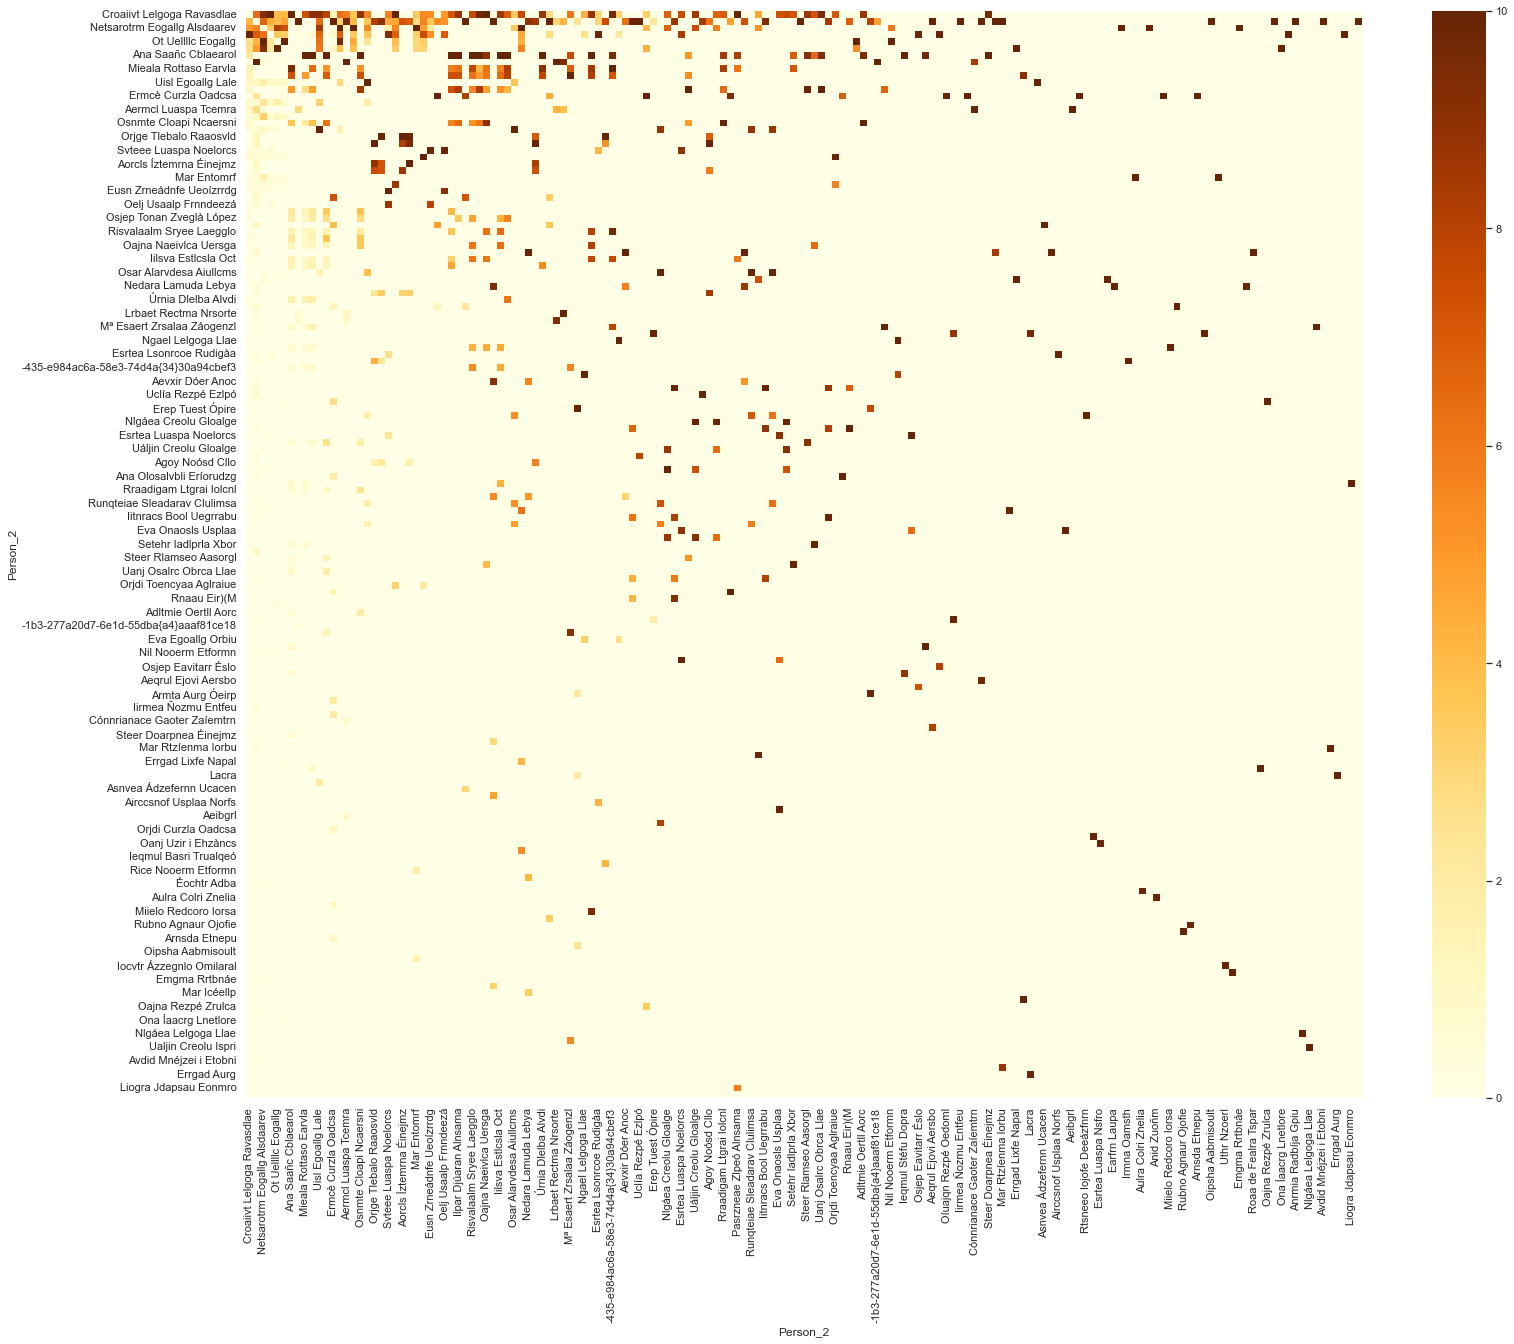

In [46]:
import seaborn as sns
sns.set(rc={'figure.figsize':(25,20)})

sns.heatmap(data=df_matrix, vmax=10, cmap="YlOrBr")
# remember that we deleted all pairs of each person with themselves.

[[Text(0, 0, ''),
  Text(1, 0, ''),
  Text(2, 0, ''),
  Text(3, 0, ''),
  Text(4, 0, ''),
  Text(5, 0, ''),
  Text(6, 0, ''),
  Text(7, 0, ''),
  Text(8, 0, ''),
  Text(9, 0, ''),
  Text(10, 0, ''),
  Text(11, 0, ''),
  Text(12, 0, ''),
  Text(13, 0, ''),
  Text(14, 0, ''),
  Text(15, 0, ''),
  Text(16, 0, ''),
  Text(17, 0, ''),
  Text(18, 0, ''),
  Text(19, 0, ''),
  Text(20, 0, ''),
  Text(21, 0, ''),
  Text(22, 0, ''),
  Text(23, 0, ''),
  Text(24, 0, ''),
  Text(25, 0, ''),
  Text(26, 0, ''),
  Text(27, 0, ''),
  Text(28, 0, ''),
  Text(29, 0, ''),
  Text(30, 0, ''),
  Text(31, 0, ''),
  Text(32, 0, ''),
  Text(33, 0, ''),
  Text(34, 0, ''),
  Text(35, 0, ''),
  Text(36, 0, ''),
  Text(37, 0, ''),
  Text(38, 0, ''),
  Text(39, 0, ''),
  Text(40, 0, ''),
  Text(41, 0, ''),
  Text(42, 0, ''),
  Text(43, 0, ''),
  Text(44, 0, ''),
  Text(45, 0, ''),
  Text(46, 0, ''),
  Text(47, 0, ''),
  Text(48, 0, ''),
  Text(49, 0, ''),
  Text(50, 0, ''),
  Text(51, 0, ''),
  Text(52, 0, ''),
  T

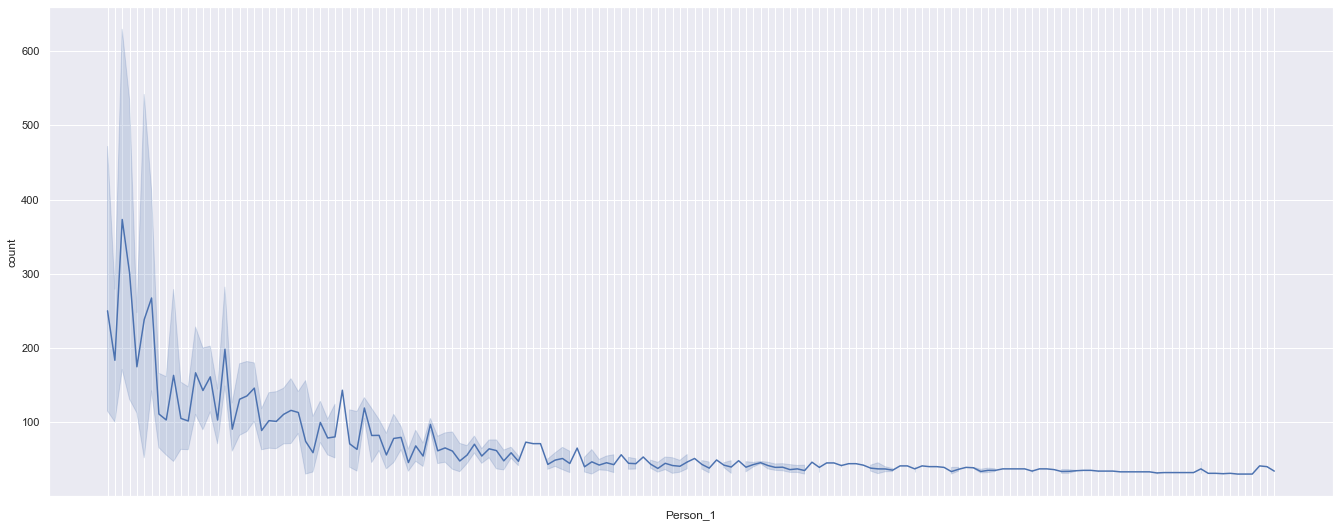

In [47]:
sns.set(rc={'figure.figsize':(23,9)})
g = sns.lineplot(data=df_trim, x='Person_1', y='count')
g.set(xticklabels=[])

#### Generate social network graph

It's time to generate the social graph. First we create a list of nodes based on the columns of the dataframe (one node per person). Then, 

The graph will open in a browser window (this behavior can be changed in the `draw_network` function).

In [48]:
nodes = df_matrix.columns.to_list()
nodes = [node.strip() for node in nodes] # Removing leading/trailing spaces. Not necessary but won't hurt.


net = draw_network(nodes, df_matrix, minimum_weight=0.1, maximum_weight=10000, repulsion=100, spring_length=200)
#net.show_buttons(filter_=True)         # Shows all config buttons in the html file. Must be disabled if set_options() is active
#net.show_buttons(filter_=['physics'])  # Shows only the physics related buttons in the html file. Must be disabled if set_options() are active

net.show("socialgraph_trimmed.html")

Static image of the trimmed global network graph (open the corresponding .html file for the interactive version):


![Global social graph, trimmed](./socialgraph_trimmed.png)



Static image of the non-trimmed global network graph (open the corresponding .html file for the interactive version):


![Global social graph, trimmed](./socialgraph_trimmed_n1.png)

### Person-centered Social graph
Instead of plotting the whole dataset, only plot the social graph relevant to one particular person. We will use the whole dataset instead of the trimmed version, since this generally won't cause a resource problem and we'll be able to visualize even the weakest relationships.

Only people linked to that person will appear in that graph. Links between those linked people will also be represented.

#### Preparing the data

The process is similar to the global graph, but in this case we filter the dataframe so only contacts related to the `target` person are kept.

In [49]:
target = "Steer Doarpnea Éinejmz"

# First, list of people linked to that person
linked_people = df[(df["Person_2"]==target)]['Person_1']
linked_people = list(linked_people)
linked_people.append(target) # add the target person as one of the linked people too, otherwise it would be excluded in the graph
print(linked_people)

# Second, remove all values in dataframe not related to the linked people
df = df[(df['Person_1'].isin(linked_people)) & (df['Person_2'].isin(linked_people))]

# Finally, remove people references to themselves. (like it was done for df_trim)
df = df[df['Person_1'] != df['Person_2']]

df.reset_index(inplace=True)
display(df)

['Steer Doarpnea Éinejmz', 'Ana Saañc Cblaearol', 'Mieala Rottaso Earvla', 'Osej Nionota Nmría Iubro', 'Croaiivt Lelgoga Ravasdlae', 'Unssaa Natsana Ouñmz', 'Osnmte Cloapi Ncaersni', 'Ldacui Etrpsau Oaaccrrs', 'Osjep Tonan Zveglà López', 'Arcme Csaoplia Uaemnl', '-b82-d6a46144-9709-b0f48{f4}ea0e8dbebf', 'Risvalaalm Sryee Laegglo', 'Oanj Aatm Gípeler', 'Ócnmia Rávshe Aesabcz', 'Aluapudeg Gaaddlori Abacrne', 'Oséj Ervio Zvleé', 'Osjep Aureberdg Ulpjo', 'Setehr Iadlprla Xbor', 'Ieqmul Luaspa Noelorcs', 'Oajna Naeivlca Uersga', 'Iilsva Estlcsla Oct', 'Muacdlmaai Sabcou Eóplz', 'Nintaoo Bioru Eczánsh', 'Ilpar Djúaran Alnsama', 'Esrtea Erari Snapal', 'Ermcè Yoab Stoovreon', 'Ieqmul Eàtlcsla Riera', 'Miielo Redcoro Iorsa', 'Úrnia Dlelba Alvdi', 'Bildouo Íztemrna Raícun', 'Orjdi Nalca Etust', 'Pasrzneae Zlpeó Alnsama', 'Mª Osjé Aerscl Oengmi', 'Arnsda Ezás Musob', 'Steer Rlamseo Aasorgl', 'Aevxir Rsalsroe Yamncpma', 'Edpro Yesre Iorbu', '-435-e984ac6a-58e3-74d4a{34}30a94cbef3', 'Enlardjoa Dspa

,index,tagid_1,Person_1,tagid_2,Person_2,count
0,8,7,Ieqmul Luaspa Noelorcs,42,Croaiivt Lelgoga Ravasdlae,2317
1,9,42,Croaiivt Lelgoga Ravasdlae,7,Ieqmul Luaspa Noelorcs,2317
2,47,192,Ana Saañc Cblaearol,193,Mieala Rottaso Earvla,471
3,48,193,Mieala Rottaso Earvla,192,Ana Saañc Cblaearol,471
4,70,192,Ana Saañc Cblaearol,194,Osej Nionota Nmría Iubro,361
...,...,...,...,...,...,...
1871,18865,2636,Odnlyaa Nhcszeá Nuebo,1914,Iilsva Estlcsla Oct,1
1872,18867,2636,Odnlyaa Nhcszeá Nuebo,2570,Aluapudeg Gaaddlori Abacrne,1
1873,18871,2636,Odnlyaa Nhcszeá Nuebo,2622,Steer Doarpnea Éinejmz,1
1874,19518,42,Croaiivt Lelgoga Ravasdlae,2524,Ócnmia Rávshe Aesabcz,1


Pivot table:

In [50]:
df_matrix = df.pivot_table(index='Person_1', columns='Person_2', values='count', fill_value=0)
df_matrix.reset_index(drop=True)

# Sort the resulting dataframe based on mean values
df_matrix = df_matrix.reindex(df_matrix.mean().sort_values(ascending=False).index, axis=1)
df_matrix = df_matrix.reindex(df_matrix.mean().sort_values(ascending=False).index, axis=0)

display(df_matrix)

Person_2,Croaiivt Lelgoga Ravasdlae,Ana Saañc Cblaearol,Ieqmul Luaspa Noelorcs,Mieala Rottaso Earvla,Osej Nionota Nmría Iubro,Ldacui Etrpsau Oaaccrrs,Osnmte Cloapi Ncaersni,Risvalaalm Sryee Laegglo,Oajna Naeivlca Uersga,Osjep Tonan Zveglà López,...,Ieqmul Eàtlcsla Riera,Odnlyaa Nhcszeá Nuebo,Enlardjoa Dsparee Aaosgld,Lulís Añóar Llgeü,-258-923d646b-1d16-69d7a{94}80d5a8c401,Ermcè Yoab Stoovreon,Netsarotrm Cllo Oasmña,Aefral Tgeaor Zlevla,Ócnmia Rávshe Aesabcz,-b82-d6a46144-9709-b0f48{f4}ea0e8dbebf
Person_2,,,,,,,,,,,,,,,,,,,,,
Croaiivt Lelgoga Ravasdlae,0,499,2317,346,328,201,164,57,74,67,...,3,3,4,2,3,4,2,2,1,0
Ana Saañc Cblaearol,499,0,28,471,361,254,186,75,66,94,...,1,1,3,0,0,3,0,2,0,0
Ieqmul Luaspa Noelorcs,2317,28,0,26,33,3,9,6,11,3,...,3,3,0,2,2,4,2,0,0,0
Mieala Rottaso Earvla,346,471,26,0,235,132,96,58,46,55,...,0,0,3,0,0,3,0,2,0,0
Osej Nionota Nmría Iubro,328,361,33,235,0,175,137,47,45,70,...,4,4,4,2,2,5,2,2,0,0
Ldacui Etrpsau Oaaccrrs,201,254,3,132,175,0,157,42,36,69,...,4,4,0,5,2,0,2,0,0,0
Osnmte Cloapi Ncaersni,164,186,9,96,137,157,0,39,67,53,...,6,6,1,2,2,0,7,2,0,0
Risvalaalm Sryee Laegglo,57,75,6,58,47,42,39,0,46,35,...,2,2,2,1,2,3,1,2,0,0
Oajna Naeivlca Uersga,74,66,11,46,45,36,67,46,0,25,...,3,3,1,2,2,3,2,2,0,0


Normalizing values:

In [51]:
from sklearn import preprocessing

x = df_matrix.values #returns a numpy array
min_max_scaler = preprocessing.MinMaxScaler((0, 10))
x_scaled = min_max_scaler.fit_transform(x)
df_matrix = pd.DataFrame(x_scaled, index=df_matrix.index, columns=df_matrix.columns)
display(df_matrix)

Person_2,Croaiivt Lelgoga Ravasdlae,Ana Saañc Cblaearol,Ieqmul Luaspa Noelorcs,Mieala Rottaso Earvla,Osej Nionota Nmría Iubro,Ldacui Etrpsau Oaaccrrs,Osnmte Cloapi Ncaersni,Risvalaalm Sryee Laegglo,Oajna Naeivlca Uersga,Osjep Tonan Zveglà López,...,Ieqmul Eàtlcsla Riera,Odnlyaa Nhcszeá Nuebo,Enlardjoa Dsparee Aaosgld,Lulís Añóar Llgeü,-258-923d646b-1d16-69d7a{94}80d5a8c401,Ermcè Yoab Stoovreon,Netsarotrm Cllo Oasmña,Aefral Tgeaor Zlevla,Ócnmia Rávshe Aesabcz,-b82-d6a46144-9709-b0f48{f4}ea0e8dbebf
Person_2,,,,,,,,,,,,,,,,,,,,,
Croaiivt Lelgoga Ravasdlae,0.000000,10.000000,10.000000,7.346072,9.085873,7.913386,8.817204,7.600000,10.000000,7.127660,...,3.75,4.285714,4.444444,4.0,5.000000,6.666667,2.857143,6.666667,2.5,0.0
Ana Saañc Cblaearol,2.153647,0.000000,0.120846,10.000000,10.000000,10.000000,10.000000,10.000000,8.918919,10.000000,...,1.25,1.428571,3.333333,0.0,0.000000,5.000000,0.000000,6.666667,0.0,0.0
Ieqmul Luaspa Noelorcs,10.000000,0.561122,0.000000,0.552017,0.914127,0.118110,0.483871,0.800000,1.486486,0.319149,...,3.75,4.285714,0.000000,4.0,3.333333,6.666667,2.857143,0.000000,0.0,0.0
Mieala Rottaso Earvla,1.493310,9.438878,0.112214,0.000000,6.509695,5.196850,5.161290,7.733333,6.216216,5.851064,...,0.00,0.000000,3.333333,0.0,0.000000,5.000000,0.000000,6.666667,0.0,0.0
Osej Nionota Nmría Iubro,1.415624,7.234469,0.142426,4.989384,0.000000,6.889764,7.365591,6.266667,6.081081,7.446809,...,5.00,5.714286,4.444444,4.0,3.333333,8.333333,2.857143,6.666667,0.0,0.0
Ldacui Etrpsau Oaaccrrs,0.867501,5.090180,0.012948,2.802548,4.847645,0.000000,8.440860,5.600000,4.864865,7.340426,...,5.00,5.714286,0.000000,10.0,3.333333,0.000000,2.857143,0.000000,0.0,0.0
Osnmte Cloapi Ncaersni,0.707812,3.727455,0.038843,2.038217,3.795014,6.181102,0.000000,5.200000,9.054054,5.638298,...,7.50,8.571429,1.111111,4.0,3.333333,0.000000,10.000000,6.666667,0.0,0.0
Risvalaalm Sryee Laegglo,0.246008,1.503006,0.025896,1.231423,1.301939,1.653543,2.096774,0.000000,6.216216,3.723404,...,2.50,2.857143,2.222222,2.0,3.333333,5.000000,1.428571,6.666667,0.0,0.0
Oajna Naeivlca Uersga,0.319379,1.322645,0.047475,0.976645,1.246537,1.417323,3.602151,6.133333,0.000000,2.659574,...,3.75,4.285714,1.111111,4.0,3.333333,5.000000,2.857143,6.666667,0.0,0.0


Graphical exploration:

<AxesSubplot:xlabel='Person_2', ylabel='Person_2'>

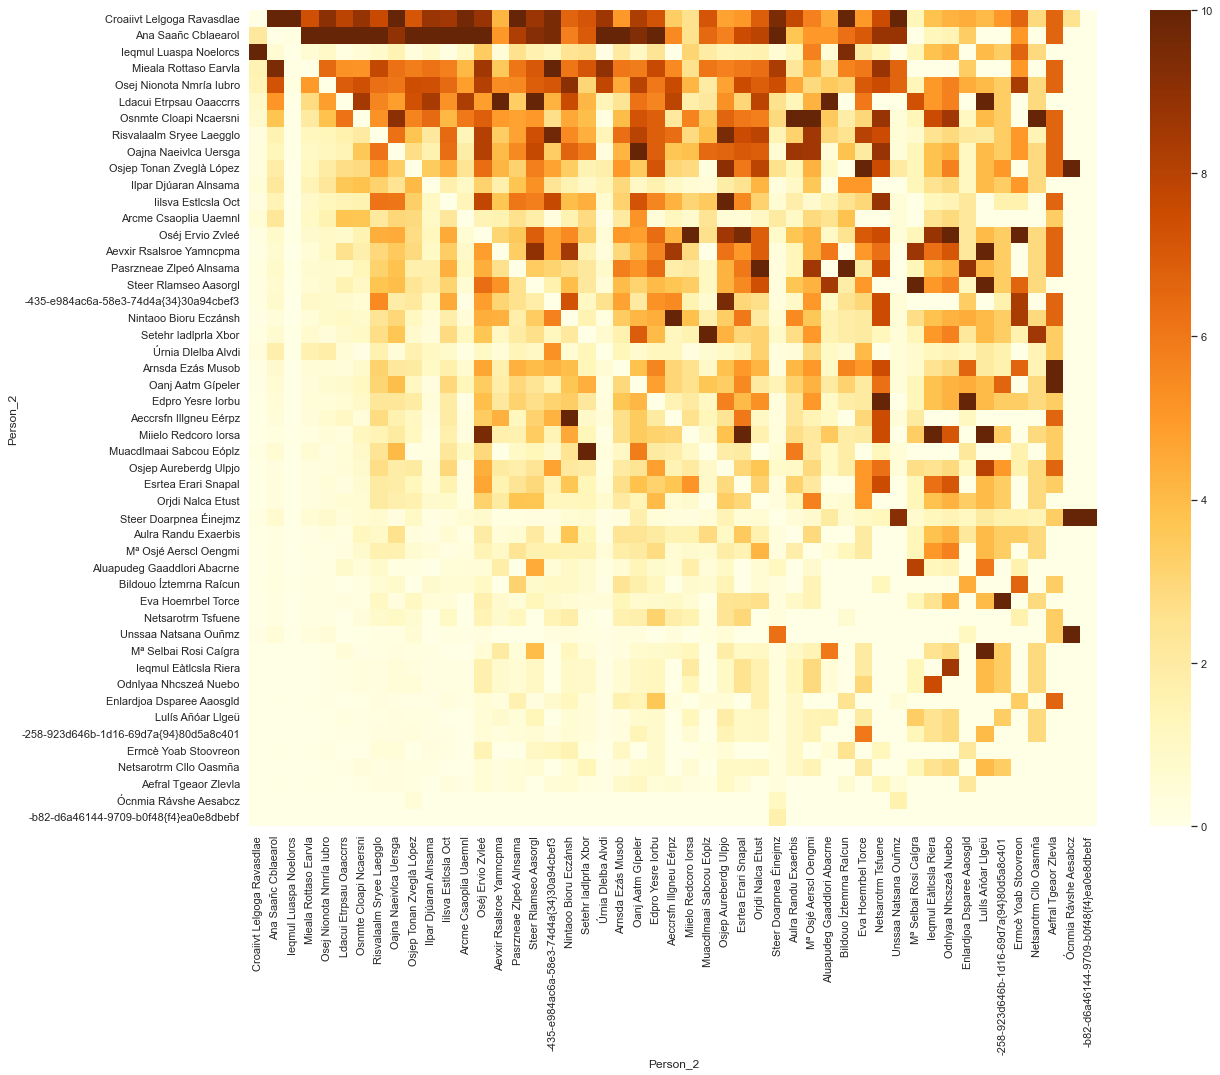

In [52]:
sns.set(rc={'figure.figsize':(19,15)})
sns.heatmap(data=df_matrix, cmap="YlOrBr")

[[Text(0, 0, ''),
  Text(1, 0, ''),
  Text(2, 0, ''),
  Text(3, 0, ''),
  Text(4, 0, ''),
  Text(5, 0, ''),
  Text(6, 0, ''),
  Text(7, 0, ''),
  Text(8, 0, ''),
  Text(9, 0, ''),
  Text(10, 0, ''),
  Text(11, 0, ''),
  Text(12, 0, ''),
  Text(13, 0, ''),
  Text(14, 0, ''),
  Text(15, 0, ''),
  Text(16, 0, ''),
  Text(17, 0, ''),
  Text(18, 0, ''),
  Text(19, 0, ''),
  Text(20, 0, ''),
  Text(21, 0, ''),
  Text(22, 0, ''),
  Text(23, 0, ''),
  Text(24, 0, ''),
  Text(25, 0, ''),
  Text(26, 0, ''),
  Text(27, 0, ''),
  Text(28, 0, ''),
  Text(29, 0, ''),
  Text(30, 0, ''),
  Text(31, 0, ''),
  Text(32, 0, ''),
  Text(33, 0, ''),
  Text(34, 0, ''),
  Text(35, 0, ''),
  Text(36, 0, ''),
  Text(37, 0, ''),
  Text(38, 0, ''),
  Text(39, 0, ''),
  Text(40, 0, ''),
  Text(41, 0, ''),
  Text(42, 0, ''),
  Text(43, 0, ''),
  Text(44, 0, ''),
  Text(45, 0, ''),
  Text(46, 0, ''),
  Text(47, 0, ''),
  Text(48, 0, '')]]

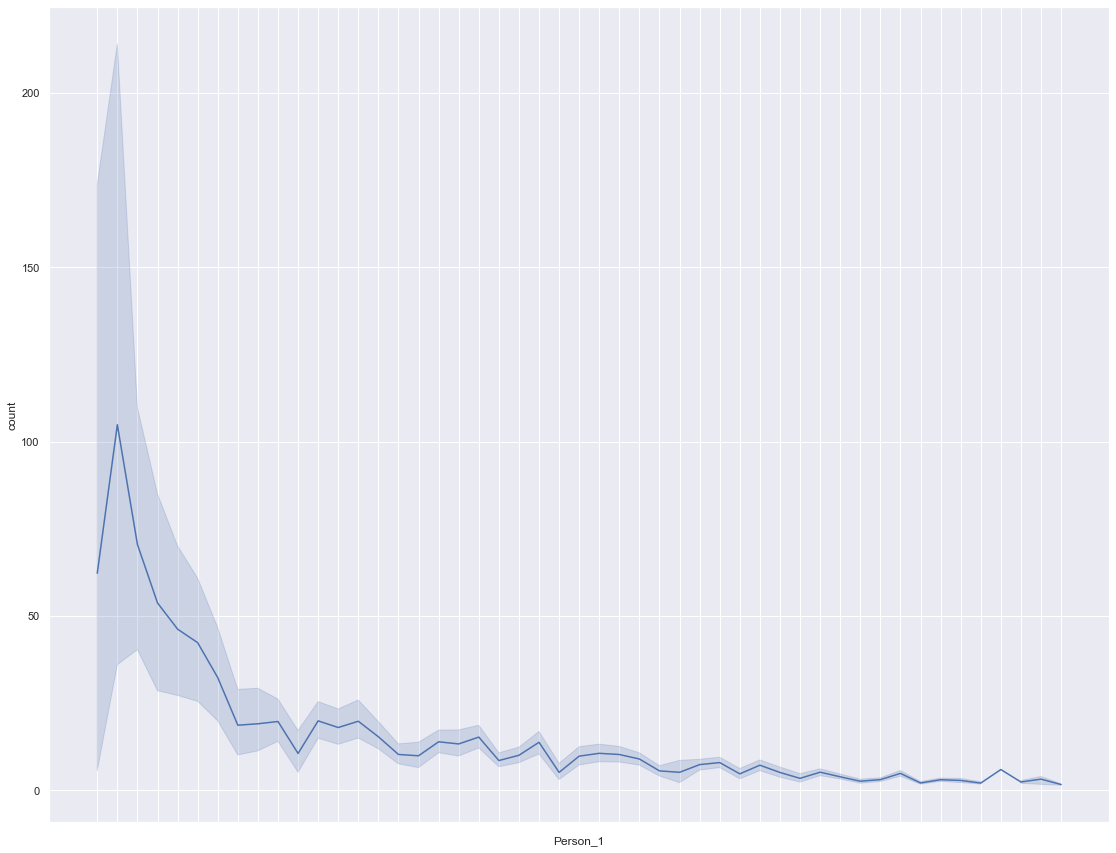

In [53]:
g = sns.lineplot(data=df, x='Person_1', y='count')
g.set(xticklabels=[])

#### Generate social network graph

In [54]:
nodes = df_matrix.columns.to_list()
nodes = [node.strip() for node in nodes]
nodes

net = draw_network(nodes, df_matrix, minimum_weight=0.1, maximum_weight=10000, repulsion=100, spring_length=200)
#net.show_buttons(filter_=True)
#net.show_buttons(filter_=['physics']) # must be disabled if set_options() are active

net.show("socialgraph_{}.html".format(target))

Static image of the person-centered social graph (open the corresponding .html file for the interactive version):


![Global social graph, trimmed](./socialgraph_Oíuajqn%20Rezpé%20Oedoml.png)

### Keyword-centered Social graph

In [125]:
# Same, but limited to just one specific Tag

tags = "Toronto, New York" # Comma separated list of keywords

tags = ' '.join('"{}",'.format(word) for word in tags.split(', ')) # We need each individual word surrounded by quotes
tags = tags[:-1] # trim the last comma
print(tags)

sqlquery = """
    SELECT A.tagid, T1.value, B.tagid, T2.value, count(DISTINCT A.imageid) AS count_pairs
    FROM ImageTags A, ImageTags B
    INNER JOIN TagProperties T1
    ON A.tagid = T1.tagid
    INNER JOIN TagProperties T2
    ON B.tagid = T2.tagid
    WHERE A.tagid IN (
            SELECT tagid FROM TagProperties
            WHERE property = 'person' AND value NOT NULL) 
        AND A.imageid = B.imageid
        AND A.imageid in (
            SELECT ImageTags.imageid
            FROM TagsTree
            INNER JOIN Tags T1
            ON TagsTree.id = T1.id
            INNER JOIN Tags T2
            ON TagsTree.pid = T2.id
            INNER JOIN ImageTags
            ON ImageTags.tagid = T1.id
            WHERE T1.name IN ({0}) OR T2.name IN ({0}))
    AND T2.value IS NOT NULL
    GROUP BY A.tagid, B.tagid
    ORDER BY count_pairs DESC"""

sqlquery = sqlquery.format(tags)
print(sqlquery)
res = cur.execute(sqlquery)
output = res.fetchall() #	    add 'AND A.tagid <> B.tagid' if you want to ignore counts of one person with itself.

"Toronto", "New York"

    SELECT A.tagid, T1.value, B.tagid, T2.value, count(DISTINCT A.imageid) AS count_pairs
    FROM ImageTags A, ImageTags B
    INNER JOIN TagProperties T1
    ON A.tagid = T1.tagid
    INNER JOIN TagProperties T2
    ON B.tagid = T2.tagid
    WHERE A.tagid IN (
            SELECT tagid FROM TagProperties
            WHERE property = 'person' AND value NOT NULL) 
        AND A.imageid = B.imageid
        AND A.imageid in (
            SELECT ImageTags.imageid
            FROM TagsTree
            INNER JOIN Tags T1
            ON TagsTree.id = T1.id
            INNER JOIN Tags T2
            ON TagsTree.pid = T2.id
            INNER JOIN ImageTags
            ON ImageTags.tagid = T1.id
            WHERE T1.name IN ("Toronto", "New York") OR T2.name IN ("Toronto", "New York"))
    AND T2.value IS NOT NULL
    GROUP BY A.tagid, B.tagid
    ORDER BY count_pairs DESC


#### Data cleaning
Convert query output into `Pandas` dataframe (`df`) and clean up the data:

In [133]:
df_tag = pd.DataFrame(output)

print(df_tag.shape)
df_tag.rename(columns={0: 'tagid_1', 1: 'Person_1', 2: 'tagid_2', 3: 'Person_2', 4: 'count'}, inplace=True)

df_tag.replace(r"^ +| +$", r"", regex=True, inplace=True)   # Replace leading and trailing spaces
df_tag = df_tag[df_tag['Person_1'] != df_tag['Person_2']]          # Avoids people to be linked with themselves. That would only show the number of photos where each person appears.
#df_tag = df_tag[df_tag['count']>=30]                 # Only keep those rows with more than X matches.

(536, 5)


In [134]:
# Scramble the names, for privacy reasons
person_1_scrambled = pd.Series([shuffle_word(words) for words in df_tag['Person_1']])
person_2_scrambled = pd.Series([shuffle_word(words) for words in df_tag['Person_2']])
df_tag['Person_1'] = person_1_scrambled
df_tag['Person_2'] = person_2_scrambled

display(df_tag)

,tagid_1,Person_1,tagid_2,Person_2,count
3,33,Aermcl Luaspa Tcemra,907,Anrmia Rectma Aegotr,537
4,907,Arcm Usaalp Eogallg,33,Aermcl Luaspa Tcemra,537
6,907,Anrmia Rectma Aegotr,5254,Lrbaet Rectma Nrsorte,203
7,5254,Lrbaet Rectma Nrsorte,907,Anrmia Rectma Aegotr,203
9,33,Lrbaet Rectma Nrsorte,5254,Niaol Rectma Kahu,132
...,...,...,...,...,...
531,5254,NaN,6265,NaN,1
532,5547,NaN,5254,NaN,1
533,6253,NaN,6265,NaN,1
534,6265,NaN,5254,NaN,1


#### Preparing the data

Pivot table: 
We first start from converting our dataframe to a more suitable format using a pivot table. We want to create a matrix (`df_matrix`) where each row and column headers represent one person, and the value is the amount of matching pictures.

The trimmed dataframe (`df_trim`) will be used to save resources and only show the more meaningful relations, but the whole dataset (`df`) could be used instead if our goal is to be as exhaustive as possible.

With the trimmed dataframe, we obtain a matrix of 84x84.

In [135]:
df_matrix = df_tag.pivot_table(index='Person_1', columns='Person_2', values='count', fill_value=0) # Change df_trim to df for the non-trimmed dataset
df_matrix.reset_index(drop=True)

# Sort the resulting dataframe based on mean values
df_matrix = df_matrix.reindex(df_matrix.mean().sort_values(ascending=False).index, axis=1)
df_matrix = df_matrix.reindex(df_matrix.mean().sort_values(ascending=False).index, axis=0)

display(df_matrix)

Person_2,Anrmia Rectma Aegotr,Aermcl Luaspa Tcemra,Arcm Usaalp Eogallg,Niaol Rectma Kahu,Lrbaet Rectma Nrsorte,Orjge Tlebalo Raaosvld,Aorcls Íztemrna Éinejmz,Osnmte Revcare Osfeect,Armta Oebtll Esrqafnau,Iocvtr Ázzegnlo Omilaral,...,Aniupla Srtoca,Tniaakkh Htatproco,Avdid Atelpnui,Amdla Patnka,Armia Mreoro Tmlencee,Helacrs Nraeblge,Uilraée Losileval,Ndeer Suzok,Omran Gerbarnaumt,Seaibl Lmoopa
Person_2,,,,,,,,,,,,,,,,,,,,,
Anrmia Rectma Aegotr,0,0,0,132,203,0,0,0,0,0,...,0,0,0,0,2,0,0,0,0,0
Aermcl Luaspa Tcemra,537,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
Arcm Usaalp Eogallg,0,537,0,27,26,32,32,53,0,18,...,2,2,0,0,0,0,0,0,0,0
Niaol Rectma Kahu,0,0,26,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Lrbaet Rectma Nrsorte,203,67,25,132,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Helacrs Nraeblge,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Uilraée Losileval,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Ndeer Suzok,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Normalizing values:
To visualize the data, and latter draw the graph it's better to first normalize the values, since some of theme are orders of magnitude larger than others. We'll use `min_max_scaler` from `sklearn` for that purpose, so all values range from 0 to 10:

In [136]:
from sklearn import preprocessing

x = df_matrix.values #returns a numpy array
min_max_scaler = preprocessing.MinMaxScaler((0, 10))
x_scaled = min_max_scaler.fit_transform(x)
df_matrix = pd.DataFrame(x_scaled, index=df_matrix.index, columns=df_matrix.columns)

display(df_matrix)

Person_2,Anrmia Rectma Aegotr,Aermcl Luaspa Tcemra,Arcm Usaalp Eogallg,Niaol Rectma Kahu,Lrbaet Rectma Nrsorte,Orjge Tlebalo Raaosvld,Aorcls Íztemrna Éinejmz,Osnmte Revcare Osfeect,Armta Oebtll Esrqafnau,Iocvtr Ázzegnlo Omilaral,...,Aniupla Srtoca,Tniaakkh Htatproco,Avdid Atelpnui,Amdla Patnka,Armia Mreoro Tmlencee,Helacrs Nraeblge,Uilraée Losileval,Ndeer Suzok,Omran Gerbarnaumt,Seaibl Lmoopa
Person_2,,,,,,,,,,,,,,,,,,,,,
Anrmia Rectma Aegotr,0.000000,0.000000,0.000000,10.000000,10.000000,0.000000,0.000000,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,10.0,0.0,0.0,0.0,0.0,0.0
Aermcl Luaspa Tcemra,10.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,...,0.0,0.0,10.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Arcm Usaalp Eogallg,0.000000,10.000000,0.000000,2.045455,1.280788,6.956522,6.956522,10.0,0.0,8.571429,...,10.0,10.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Niaol Rectma Kahu,0.000000,0.000000,4.905660,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Lrbaet Rectma Nrsorte,3.780261,1.247672,4.716981,10.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Helacrs Nraeblge,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Uilraée Losileval,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Ndeer Suzok,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Graphical exploration of `df_matrix`:

From what can be observed, there's a few people that appear with a diverse amount of people, but other people pairs appear almost exclusively together but not with other people.

<AxesSubplot:xlabel='Person_2', ylabel='Person_2'>

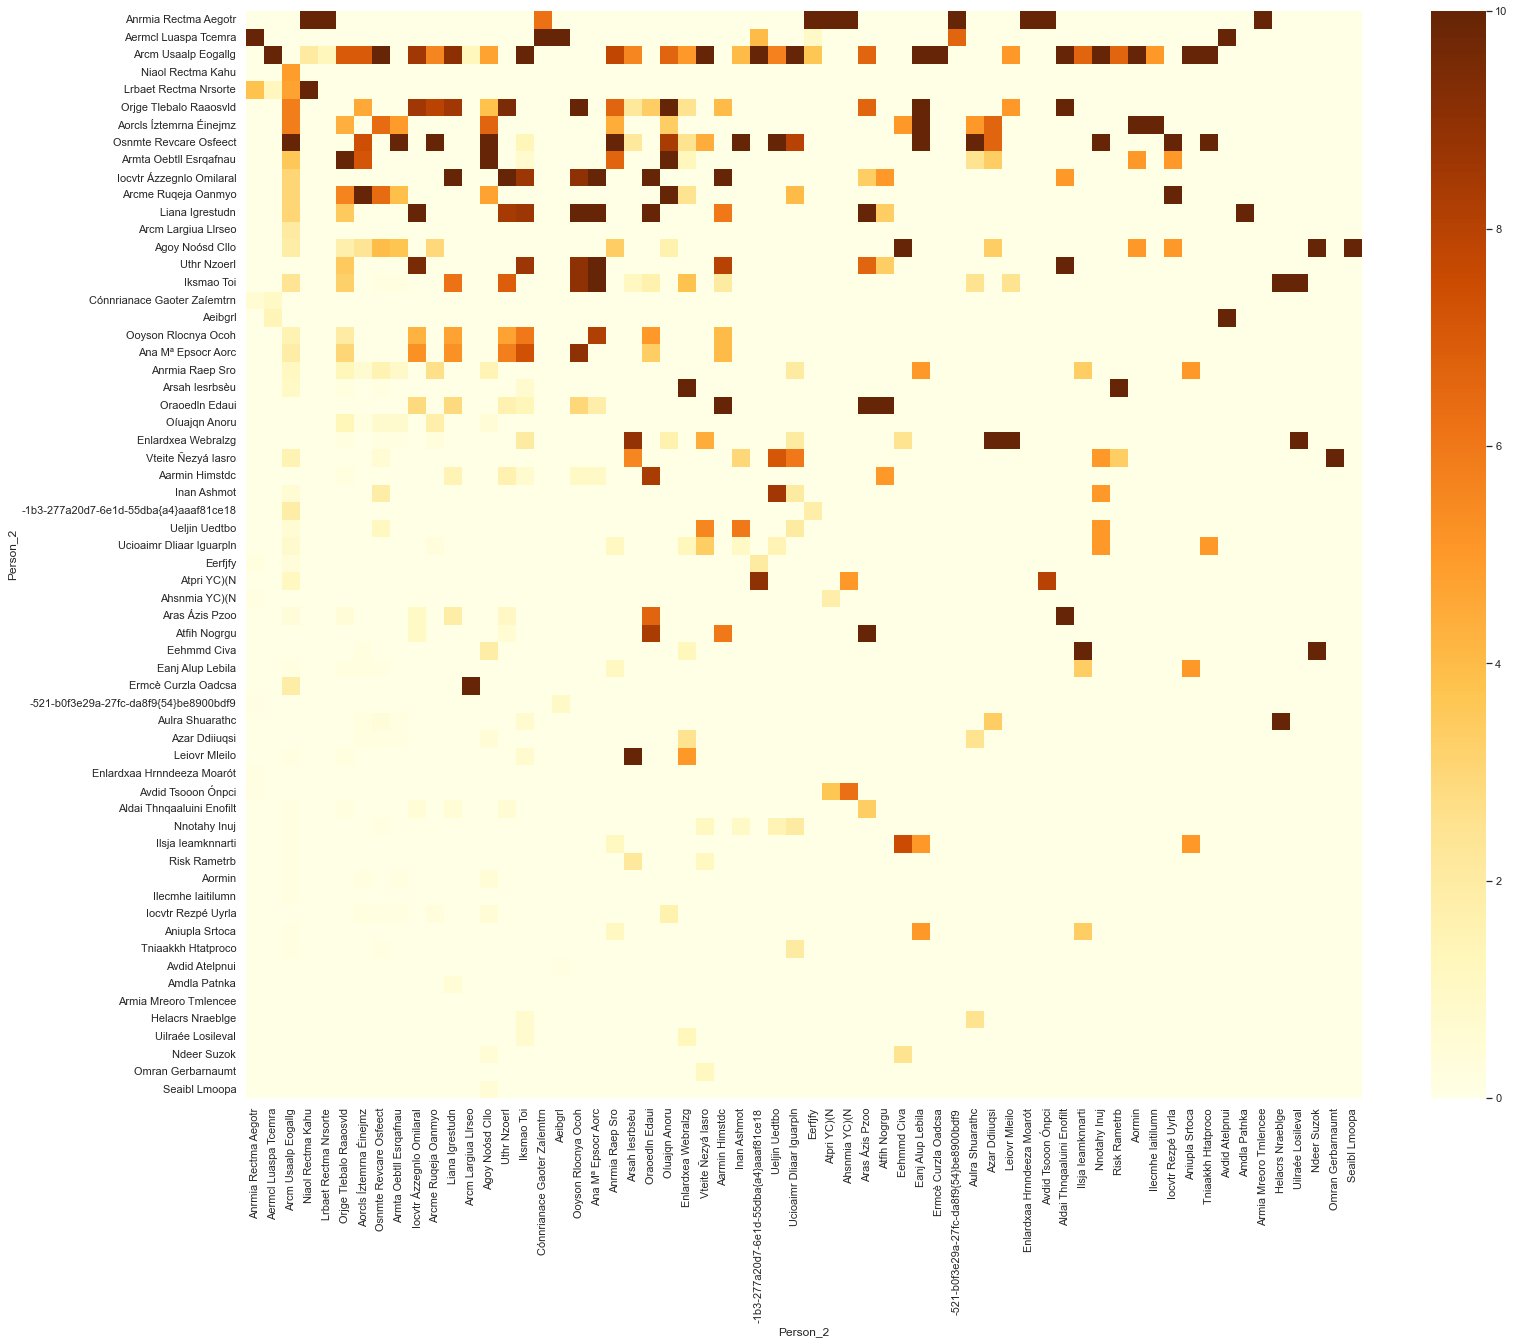

In [137]:
import seaborn as sns
sns.set(rc={'figure.figsize':(25,20)})

sns.heatmap(data=df_matrix, vmax=10, cmap="YlOrBr")
# remember that we deleted all pairs of each person with themselves.

[[Text(0, 0, ''),
  Text(1, 0, ''),
  Text(2, 0, ''),
  Text(3, 0, ''),
  Text(4, 0, ''),
  Text(5, 0, ''),
  Text(6, 0, ''),
  Text(7, 0, ''),
  Text(8, 0, ''),
  Text(9, 0, ''),
  Text(10, 0, ''),
  Text(11, 0, ''),
  Text(12, 0, ''),
  Text(13, 0, ''),
  Text(14, 0, ''),
  Text(15, 0, ''),
  Text(16, 0, ''),
  Text(17, 0, ''),
  Text(18, 0, ''),
  Text(19, 0, ''),
  Text(20, 0, ''),
  Text(21, 0, ''),
  Text(22, 0, ''),
  Text(23, 0, ''),
  Text(24, 0, ''),
  Text(25, 0, ''),
  Text(26, 0, ''),
  Text(27, 0, ''),
  Text(28, 0, ''),
  Text(29, 0, ''),
  Text(30, 0, ''),
  Text(31, 0, ''),
  Text(32, 0, ''),
  Text(33, 0, ''),
  Text(34, 0, ''),
  Text(35, 0, ''),
  Text(36, 0, ''),
  Text(37, 0, ''),
  Text(38, 0, ''),
  Text(39, 0, ''),
  Text(40, 0, ''),
  Text(41, 0, ''),
  Text(42, 0, ''),
  Text(43, 0, ''),
  Text(44, 0, ''),
  Text(45, 0, ''),
  Text(46, 0, ''),
  Text(47, 0, ''),
  Text(48, 0, ''),
  Text(49, 0, ''),
  Text(50, 0, ''),
  Text(51, 0, ''),
  Text(52, 0, ''),
  T

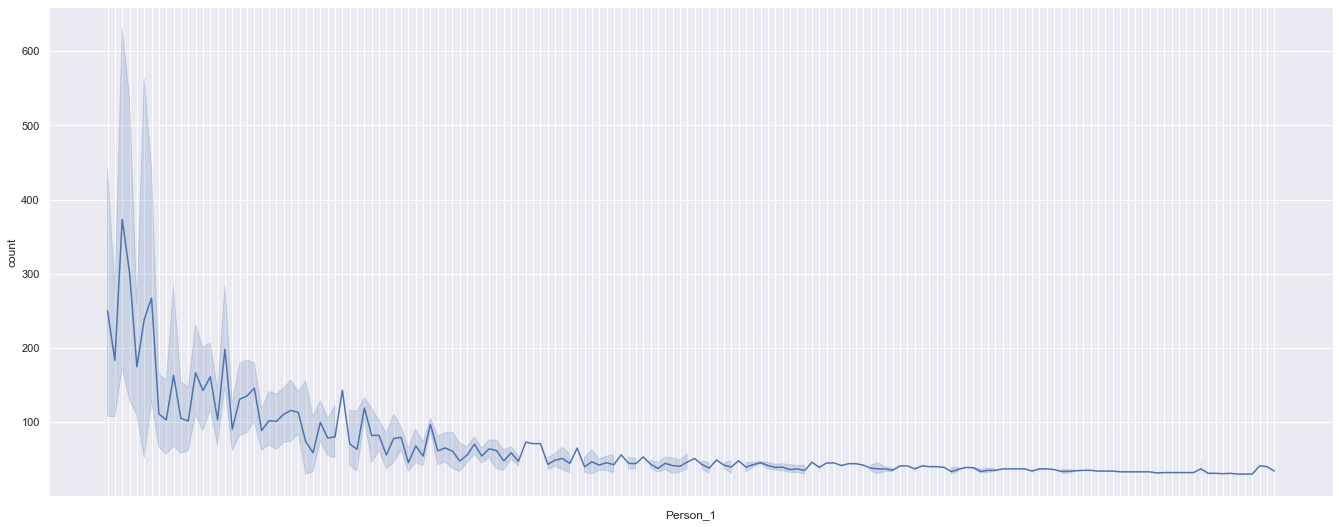

In [138]:
sns.set(rc={'figure.figsize':(23,9)})
g = sns.lineplot(data=df_trim, x='Person_1', y='count')
g.set(xticklabels=[])

#### Generate social network graph

It's time to generate the social graph. First we create a list of nodes based on the columns of the dataframe (one node per person). Then, 

The graph will open in a browser window (this behavior can be changed in the `draw_network` function).

In [139]:
nodes = df_matrix.columns.to_list()
nodes = [node.strip() for node in nodes] # Removing leading/trailing spaces. Not necessary but won't hurt.


net = draw_network(nodes, df_matrix, minimum_weight=0.1, maximum_weight=10000, repulsion=100, spring_length=200)
#net.show_buttons(filter_=True)         # Shows all config buttons in the html file. Must be disabled if set_options() is active
#net.show_buttons(filter_=['physics'])  # Shows only the physics related buttons in the html file. Must be disabled if set_options() are active

tags = tags.replace(", ", "_")
tags = tags.replace("\"", "")
net.show(f"socialgraph_{tags}.html")

Static image of the graph for people in pictures tagged with "Toronto" or "New York". Open the corresponding .html file for the interactive version):

![Graph for people in pictures tagged with "Toronto" or "New York"](./socialgraph_Toronto_New%20York.png)